导入数据集

In [1406]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn import preprocessing

In [1407]:
train_df = pd.read_csv("C:/Users/Administrator/future/input/train_data.csv",index_col = 0)
test_df = pd.read_csv("C:/Users/Administrator/future/input/test_a.csv",index_col = 0)

In [1408]:
train_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


查看数据

In [1409]:
train_df["rentType"].unique()

array(['未知方式', '整租', '合租', '--'], dtype=object)

In [1417]:
train_df["area"].describe()
"""
area可能需要处理,存在异常值
"""

#train_df["rentType"].value_counts()
"""
rentType"缺失值太多,直接去掉这一列特征
"""

#train_df["houseType"].unique()
"""
"houseType"可能需要提取特征
"""

#train_df["houseFloor"].unique()
"""
"houseFloor"需要将类别型变量转变为数字型变量
"""
#train_df["houseToward"].value_counts()
"""
tradeMoney包含大异常值,需要处理
"""
train_df['tradeMoney'].sort_values(ascending = False).head(10)
'''
totalFloor包含大量异常值,也需要进行处理
'''
train_df['totalFloor'].sort_values(ascending = True).head(10)

train_df['buildYear'].unique()

array(['1953', '2007', '暂无信息', '2003', '2014', '1997', '1993', '1994',
       '1998', '2000', '1995', '1999', '2015', '1981', '2002', '2010',
       '2011', '1989', '1983', '2001', '2012', '1996', '2004', '2006',
       '2009', '2008', '1984', '2017', '1976', '1986', '1988', '1992',
       '2005', '1987', '2016', '1965', '1990', '1985', '1978', '2013',
       '1980', '1954', '1982', '1968', '1940', '1966', '1970', '1937',
       '1979', '1974', '1964', '1991', '1977', '1956', '1930', '1952',
       '1957', '1936', '1967', '1972', '1975', '1955', '1949', '1912',
       '1958', '1973', '1932', '1963', '1931', '1926', '1939', '1951',
       '1960', '1910', '1969', '1920', '1959', '1962', '1961', '1950'],
      dtype=object)

In [1418]:
def shaixuan (df):
    df = df[(df["area"]>0)&(df["area"] < 1000)].copy()
    df = df[df["totalFloor"]>0].copy()
    return df

In [1419]:
def shaixuan_train (df):
    df = df[(df["tradeMoney"]>0)&(df["tradeMoney"] < 100000)].copy()
    return df

In [1420]:
def washdata(df):
    """
    处理houseType
    """
    df["shi"] = df.houseType.astype('str').apply(lambda x:int(x[0:1]))
    df["ting"] =df.houseType.astype('str').apply(lambda x:int(x[2:3]))
    df["wei"] = df.houseType.astype('str').apply(lambda x:int(x[4:5]))

    """
    处理houseFloor
    """
    df.loc[df["houseFloor"] == "低","houseFloor"] =1
    df.loc[df["houseFloor"] == "中","houseFloor"] =2
    df.loc[df["houseFloor"] == "高","houseFloor"] =3
    
    """
    处理houseTward,将暂无数据替换为"南"
    """
    df["houseToward"]=df["houseToward"].replace("暂无数据","南")
    #df["houseTward"].value_counts()
    
    """
    将buildYear进行类型转换,转换为int类型,并对缺失值进行填充
    """
    df["buildYear"] = df["buildYear"].replace("暂无信息",0) 
    df["buildYear"] = df["buildYear"].astype(int)
    df["buildYear"] = df["buildYear"].fillna(df["buildYear"].mean())
    
    """
    处理"pv"和"uv"
    """
    df["pv"] = df["pv"].fillna(df["pv"].mean())
    df["uv"] = df["uv"].fillna(df["uv"].mean())
    df["pv_uv"] = df["pv"]/df["uv"]
    
    """
    处理"tradeTime",提取交易年份
    """
    df['tradeYear'] = df.tradeTime.apply(lambda x: int(x.split('/')[0]))
    df['tradeMonth'] = df.tradeTime.apply(lambda x: int(x.split('/')[1]))
    df['build_trade'] =df['tradeYear'] - df['buildYear']
                                           
    df['rentType']= df['rentType'].replace(['未知方式','整租','合租','--'],[0,1,2,3],inplace=True)
    df['houseDecoration'].replace([u'其他',u'简装',u'精装','毛坯'],[0,1,2,3],inplace=True)
    #df['houseToward'].replace(['暂无数据','西南','西北','西','南北','南','东西','东南','东','北'],[0,1,2,3,4,5,6,7,8,9],inplace=True)                                       
    le = preprocessing.LabelEncoder()
    le.fit(df['communityName'])
    df['communityName'] = le.transform(df['communityName'])

    le.fit(df['region'])
    df['region'] = le.transform(df['region'])

    le.fit(df['plate'])
    df['plate'] = le.transform(df['plate'])
   
                                       
    return df

In [1421]:
#train_df['plate'].value_counts()

In [1431]:
feature = ['area','totalFloor','region','plate','subwayStationNum','busStationNum','interSchoolNum','privateSchoolNum','communityName','bankNum','hospitalNum','parkNum','shopNum','shi','ting','wei','build_trade','pv_uv']

In [1432]:
train_1 = shaixuan(train_df)
train_12 =shaixuan_train(train_1)
train_data=washdata(train_12)
train_data.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,lookNum,tradeTime,tradeMoney,shi,ting,wei,pv_uv,tradeYear,tradeMonth,build_trade
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,None,2室1厅1卫,1,16,南,0,50,SH,0,...,0,2018/11/28,2000.0,2,1,1,3.957746,2018,11,65
100307942,125.55,None,3室2厅2卫,2,14,南,1,129,SH,1,...,1,2018/12/16,2000.0,3,2,2,31.863636,2018,12,11
100307764,132.00,None,3室2厅2卫,1,32,南,0,178,SH,1,...,1,2018/12/22,16000.0,3,2,2,2.850000,2018,12,2018
100306518,57.00,None,1室1厅1卫,2,17,南,2,312,SH,1,...,9,2018/12/21,1600.0,1,1,1,3.182796,2018,12,2018
100305262,129.00,None,3室2厅3卫,1,2,南,3,1256,SH,2,...,0,2018/11/18,2900.0,3,2,3,4.245833,2018,11,2018


In [1433]:
train_data['houseDecoration'].value_counts()

0    29009
2    10913
1     1170
3      311
Name: houseDecoration, dtype: int64

In [1434]:
test_1 =shaixuan(test_df)
test_data = washdata(test_1)
test_data.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,uv,lookNum,tradeTime,shi,ting,wei,pv_uv,tradeYear,tradeMonth,build_trade
ID,,,,,,,,,,,,,,,,,,,,,
100000079,36.54,None,1室1厅1卫,3,21,西北,0,2236,SH,11,...,397.0,2,2018/10/25,1,1,1,4.032746,2018,10,10
100000138,64.00,None,2室1厅1卫,3,11,南北,0,494,SH,1,...,3066.0,0,2018/8/19,2,1,1,6.889432,2018,8,9
100000192,98.00,None,3室1厅1卫,3,6,南,2,512,SH,1,...,2554.0,0,2018/3/4,3,1,1,6.840642,2018,3,22
100000200,43.45,None,1室1厅1卫,3,6,南,0,476,SH,1,...,2016.0,0,2018/2/3,1,1,1,9.539187,2018,2,24
100000430,92.00,None,2室2厅1卫,3,6,南,0,770,SH,1,...,2957.0,0,2018/3/14,2,2,1,8.856611,2018,3,14


In [1435]:
y_train = train_data['tradeMoney'].copy()

In [1436]:
train_feature = train_data[feature].copy()
test_feature = test_data[feature].copy()
all_df =pd.concat((train_feature, test_feature), axis=0)
#train_feature.shape[1],test_feature.shape[1]
#train_feature.head()
#train_feature.head()

In [1437]:
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,area,totalFloor,region,plate,subwayStationNum,busStationNum,interSchoolNum,privateSchoolNum,communityName,bankNum,hospitalNum,parkNum,shopNum,shi,ting,wei,build_trade,lookNum,pv_uv
ID,,,,,,,,,,,,,,,,,,,
100309852,68.06,16,0,63,7,36,0,1,50,16,1,5,76,2,1,1,65,0,3.957746
100307942,125.55,14,1,48,2,184,0,0,129,16,1,6,163,3,2,2,11,1,31.863636
100307764,132.00,32,1,49,6,60,1,2,178,37,3,6,85,3,2,2,2018,1,2.850000
100306518,57.00,17,1,50,3,364,2,1,312,47,8,3,358,1,1,1,2018,9,3.182796
100305262,129.00,2,2,43,0,141,0,0,1256,10,0,5,100,3,2,3,2018,0,4.245833


In [1438]:
dummy_train_df = all_dummy_df.loc[train_feature.index]   #one_hot处理后的训练集
dummy_test_df = all_dummy_df.loc[test_feature.index]     #one_hot处理后的测试集
dummy_train_df.shape[1],  dummy_test_df.shape[1]

(19, 19)

建立模型

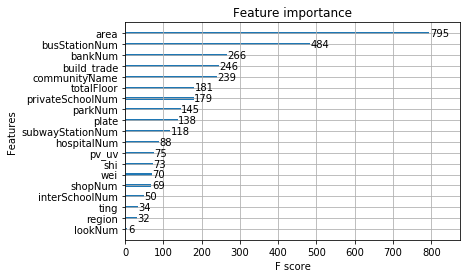

In [1439]:
# XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(dummy_train_df, y_train, test_size=0.2, random_state=0)
 
model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='reg:gamma')
model.fit(X_train, y_train)
 
# 对测试集进行预测
ans = model.predict(X_test)
 
# 显示重要特征
#fig = plt.figure(figsize=(20,10))
plot_importance(model)
plt.show()

In [1440]:
y_pro = model.predict(dummy_test_df)

In [1349]:
submission_df = pd.DataFrame(data = y_pro)

In [1352]:
submission_df.to_csv("C:/Users/Administrator/future/output/submit.csv",index =None,header =None)

In [1442]:
submission_df.head(5)

,0
0,3586.023438
1,5360.093262
2,6201.638184
3,3682.248779
4,2525.650146
